# Category classification for morphological galaxy classification #3.3 (lr = 1e-02)
---
**Author:** Jorge Barrio Conde

**Tfms:** `[Normalize.from_stats(mean=0.0, std=1.0), Rotate(p=1.0, draw=random_rotation), GaussianNoise()]`

**Images size**: 200x200 pixels

**Neural Network:** ResNet50

**Training method:** `fine_tune()`

**Epochs:** 20

**Learning rate:** 1e-02

Paper: *A catalog of visual-like mophologies in the 5 CANDELS fields using Deep-Learning* (M. Huertas-Company, 2015)

## 0. Install fastai and fastbook (Google Colab)

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

## 1. Setup

### Imports

In [ ]:
import fastai
from fastai.vision.all import *
from fastbook import *

fastai.__version__

'2.3.0'

### Paths

In [ ]:
# Specify project path
project_root_path = "/content/gdrive/MyDrive/galaxy_morphological_classification/"

In [ ]:
dataset_path = project_root_path + "datasets/rgb_200x200/"
csv_results_path = project_root_path + "src/classification/results/3.3-1e-02-TFMS-ResNet50-fine_tune-20_epochs.csv"

## 2. My functions

### 2.1. Tfms

In [ ]:
def random_rotation(x):
    '''
    Return a float tensor equal in size to batch with random
    rotations multiples of 90. 
    
    x: full batch tensor
    '''
    size = x.size(0)
    result = torch.zeros(([size]), dtype=float, device='cuda')
    
    for i in range(size):
        degree = torch.rand(1)
        if (degree < 0.25):
            result[i] = 0.0
        elif (degree < 0.5):
            result[i] = 90.0
        elif (degree < 0.75):
            result[i] = 180.0
        else:
            result[i] = 270.0
    
    return result

In [ ]:
class GaussianNoise(Transform):
    order = 100 #after normalize
    
    def encodes(self, x:TensorImage):
        noise = torch.normal(
            mean=0.0, 
            std=0.005,
            size=x.shape,
            device='cuda'
        )
        return x + noise

### 2.2. Others

In [ ]:
def datasets_info(dls):
    for ds_i, ds in enumerate([dls.train_ds, dls.valid_ds]):
        
        ds_name = "TRAIN" if ds_i == 0 else "VALID"
        print(f"Dataset: {ds_name}")
        print(ds)

        categories = [0,0,0,0,0,0]

        for data in ds:
            categories[data[1]] += 1

        for i, cat in enumerate(categories):
            print(f" - {dls.vocab[i]}:  \t{cat} ({(cat/len(ds))*100:.1f}%)")
        
        print("")

## 3. Experiment:

### 3.1. DataBlock and DataLoaders

In [ ]:
tfms = [Normalize.from_stats(mean=0.0, std=1.0), Rotate(p=1.0, draw=random_rotation), GaussianNoise()]

blocks = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = Pipeline([
        attrgetter("name"), 
        RegexLabeller(pat = r'^(.*)_\d+_.*.png')
    ]),
    batch_tfms = tfms
)

dls = blocks.dataloaders(source=dataset_path)

### 3.2. Show details

In [ ]:
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
datasets_info(dls)

Dataset: TRAIN
(#2768) [(PILImage mode=RGB size=200x200, TensorCategory(5)),(PILImage mode=RGB size=200x200, TensorCategory(0)),(PILImage mode=RGB size=200x200, TensorCategory(2)),(PILImage mode=RGB size=200x200, TensorCategory(2)),(PILImage mode=RGB size=200x200, TensorCategory(5)),(PILImage mode=RGB size=200x200, TensorCategory(2)),(PILImage mode=RGB size=200x200, TensorCategory(2)),(PILImage mode=RGB size=200x200, TensorCategory(0)),(PILImage mode=RGB size=200x200, TensorCategory(2)),(PILImage mode=RGB size=200x200, TensorCategory(0))...]
 - DISK:  	731 (26.4%)
 - DISKIRR:  	287 (10.4%)
 - DISKSPH:  	795 (28.7%)
 - IRR:  	70 (2.5%)
 - NONE:  	131 (4.7%)
 - SPH:  	754 (27.2%)

Dataset: VALID
(#692) [(PILImage mode=RGB size=200x200, TensorCategory(5)),(PILImage mode=RGB size=200x200, TensorCategory(0)),(PILImage mode=RGB size=200x200, TensorCategory(5)),(PILImage mode=RGB size=200x200, TensorCategory(0)),(PILImage mode=RGB size=200x200, TensorCategory(2)),(PILImage mode=RGB size=200x2

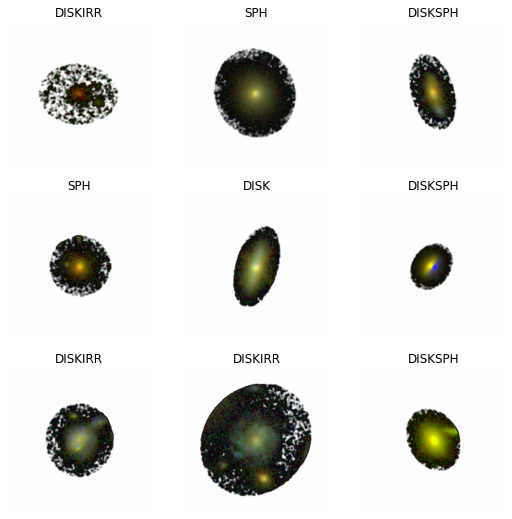

In [ ]:
dls.show_batch()

### 3.3. Learner and Training

In [ ]:
learn = cnn_learner(
    dls, resnet50, 
    metrics=accuracy, 
    cbs = [
        ShowGraphCallback(),
        CSVLogger(fname=csv_results_path, append=true)
    ]
)

Minimum/10: 6.92e-03, steepest point: 6.92e-04


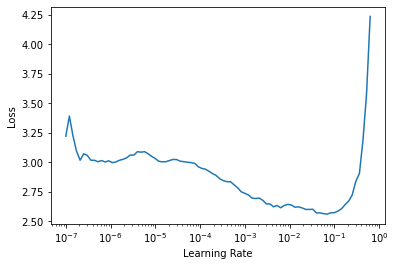

In [ ]:
lr_min, lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

epoch,train_loss,valid_loss,accuracy,time
0,2.147006,1.749696,0.498555,00:25


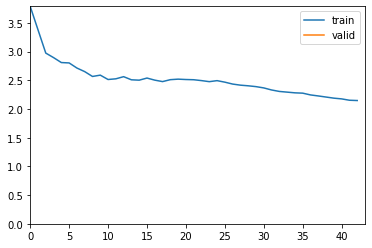

epoch,train_loss,valid_loss,accuracy,time
0,1.418253,1.203254,0.573699,00:33
1,1.246458,1.097368,0.592486,00:34
2,1.125592,1.205978,0.582370,00:34
3,1.071207,1.333656,0.546243,00:34
4,0.998721,1.307405,0.557803,00:34
5,1.001486,1.589637,0.595376,00:34
6,0.994946,0.980014,0.643064,00:35
7,0.911694,0.969206,0.630058,00:35
8,0.838174,0.915073,0.671965,00:35
9,0.789612,1.087211,0.573699,00:35


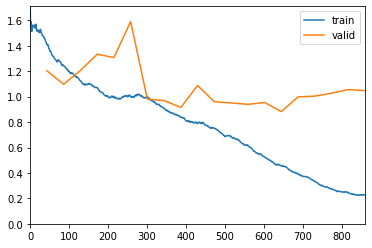

In [ ]:
learn.fine_tune(epochs=20, base_lr=1e-02)

### 3.4. Results

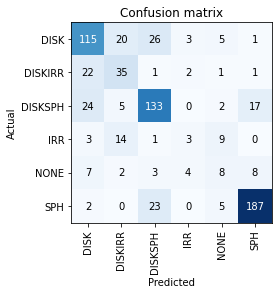

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=20)

[('DISK', 'DISKSPH', 26),
 ('DISKSPH', 'DISK', 24),
 ('SPH', 'DISKSPH', 23),
 ('DISKIRR', 'DISK', 22),
 ('DISK', 'DISKIRR', 20)]

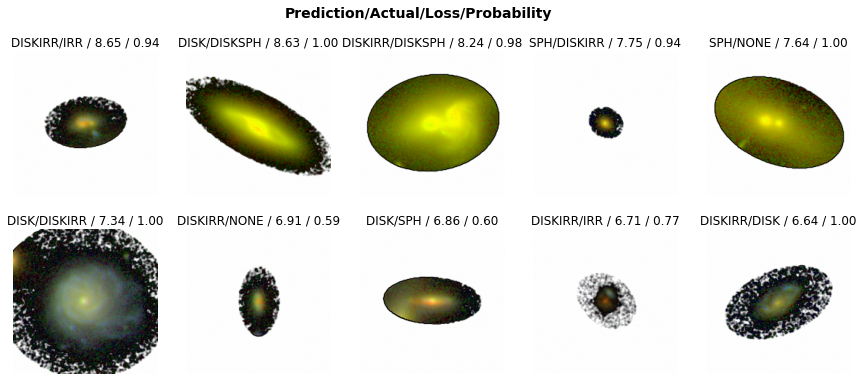

In [ ]:
interp.plot_top_losses(10, nrows=2)